In [1]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import xarray as xr
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

import matplotlib.pyplot as plt
from matplotlib import animation

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

# from utils import io, abi, glm, nexrad
from utils import io, abi

In [2]:
goes_data_path = './data/GOES16'

In [3]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'

In [12]:
dates = [datetime(2018,6,19,16) + timedelta(hours=i) for i in range(8)]
abi_files = list(sum([sorted(io.find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=3, 
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))
             

abi_files = {io.get_goes_date(i):i for i in abi_files}
abi_dates = list(abi_files.keys())
len(abi_files)


96

In [20]:
# Load a stack of goes datasets using xarray. Select a region over Northern Florida. (full file size in 1500x2500 pixels)
goes_ds = xr.open_mfdataset(abi_files.values(), concat_dim='t', combine='nested').isel({'x':slice(1300,1550), 'y':slice(650,900)})

In [21]:
goes_ds

<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 96, x: 250, y: 250)
Coordinates:
    band_id_C12                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C11                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C10                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C15                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C07                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C06                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C01                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C03                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C03                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C09                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C01                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C06                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C09                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C08                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C14                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C04                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C14                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C08                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C04                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C11                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C13                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C15                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C02                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    x_image                                 float32 -0.03136
    band_wavelength_C02                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    y_image                                 float32 0.08624
    band_wavelength_C12                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C10                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C13                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C16                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C05                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C16                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C07                             (band) int8 dask.array<chunksize=(1,), meta=np.ndarray>
    band_wavelength_C05                     (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
  * y                                       (y) float32 0.091812 ... 0.077868
  * x                                       (x) float32 -0.028531998 ... -0.0...
  * t                                       (t) datetime64[ns] 2018-06-19T16:...
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables:
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    DQF_C01     

Text(0.5, 1.0, 'Ch16: "C02"')

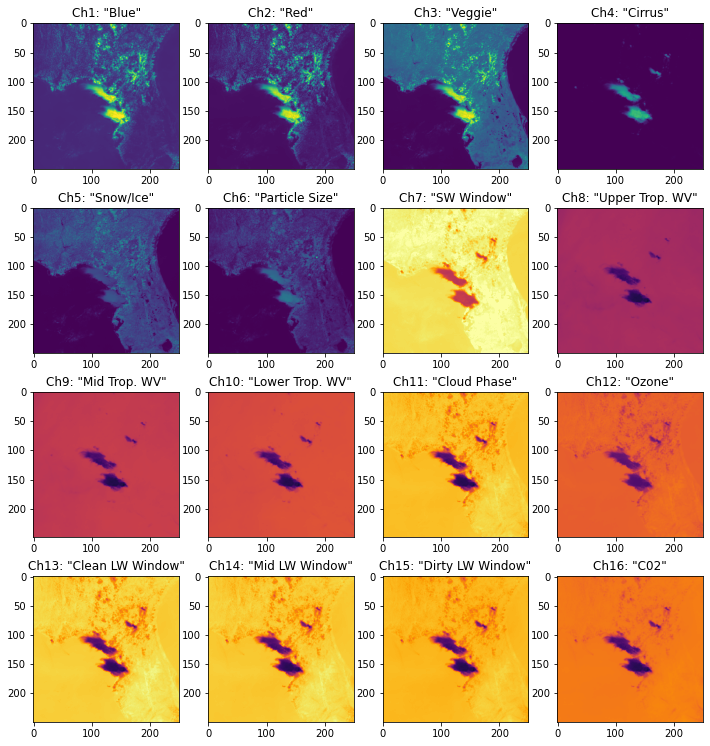

In [22]:
# Now plot all 16 channels
i = 24

fig, ax = plt.subplots(4,4, figsize=(12,13))
ax[0,0].imshow(goes_ds.CMI_C01[i], cmap='viridis', vmin=0, vmax=1)
ax[0,0].set_title('Ch1: "Blue"')

ax[0,1].imshow(goes_ds.CMI_C02[i], cmap='viridis', vmin=0, vmax=1)
ax[0,1].set_title('Ch2: "Red"')

ax[0,2].imshow(goes_ds.CMI_C03[i], cmap='viridis', vmin=0, vmax=1)
ax[0,2].set_title('Ch3: "Veggie"')

ax[0,3].imshow(goes_ds.CMI_C04[i], cmap='viridis', vmin=0, vmax=1)
ax[0,3].set_title('Ch4: "Cirrus"')

ax[1,0].imshow(goes_ds.CMI_C05[i], cmap='viridis', vmin=0, vmax=1)
ax[1,0].set_title('Ch5: "Snow/Ice"')

ax[1,1].imshow(goes_ds.CMI_C06[i], cmap='viridis', vmin=0, vmax=1)
ax[1,1].set_title('Ch6: "Particle Size"')

ax[1,2].imshow(goes_ds.CMI_C07[i], cmap='inferno', vmin=190, vmax=310)
ax[1,2].set_title('Ch7: "SW Window"')

ax[1,3].imshow(goes_ds.CMI_C08[i], cmap='inferno', vmin=190, vmax=310)
ax[1,3].set_title('Ch8: "Upper Trop. WV"')

ax[2,0].imshow(goes_ds.CMI_C09[i], cmap='inferno', vmin=190, vmax=310)
ax[2,0].set_title('Ch9: "Mid Trop. WV"')

ax[2,1].imshow(goes_ds.CMI_C10[i], cmap='inferno', vmin=190, vmax=310)
ax[2,1].set_title('Ch10: "Lower Trop. WV"')

ax[2,2].imshow(goes_ds.CMI_C11[i], cmap='inferno', vmin=190, vmax=310)
ax[2,2].set_title('Ch11: "Cloud Phase"')

ax[2,3].imshow(goes_ds.CMI_C12[i], cmap='inferno', vmin=190, vmax=310)
ax[2,3].set_title('Ch12: "Ozone"')

ax[3,0].imshow(goes_ds.CMI_C13[i], cmap='inferno', vmin=190, vmax=310)
ax[3,0].set_title('Ch13: "Clean LW Window"')

ax[3,1].imshow(goes_ds.CMI_C14[i], cmap='inferno', vmin=190, vmax=310)
ax[3,1].set_title('Ch14: "Mid LW Window"')

ax[3,2].imshow(goes_ds.CMI_C15[i], cmap='inferno', vmin=190, vmax=310)
ax[3,2].set_title('Ch15: "Dirty LW Window"')

ax[3,3].imshow(goes_ds.CMI_C16[i], cmap='inferno', vmin=190, vmax=310)
ax[3,3].set_title('Ch16: "C02"')


In [16]:
# Test preprocessed gridded radar/glm file
# Note: these files have been produced using ./scripts/process_nexrad.py
# regrid_files = ['./data/regrid/regrid_20180619_160000.nc', 
#                 './data/regrid/regrid_20180619_170000.nc', 
#                 './data/regrid/regrid_20180619_180000.nc', 
#                 './data/regrid/regrid_20180619_190000.nc']
regrid_files = ['./data/regrid/regrid_%s.nc' % (date.strftime('%Y%m%d_%H0000')) for date in dates]
print(regrid_files)
grid_ds = xr.open_mfdataset(regrid_files, concat_dim='t', combine='nested')

['./data/regrid/regrid_20180619_160000.nc', './data/regrid/regrid_20180619_170000.nc', './data/regrid/regrid_20180619_180000.nc', './data/regrid/regrid_20180619_190000.nc', './data/regrid/regrid_20180619_200000.nc', './data/regrid/regrid_20180619_210000.nc', './data/regrid/regrid_20180619_220000.nc', './data/regrid/regrid_20180619_230000.nc']


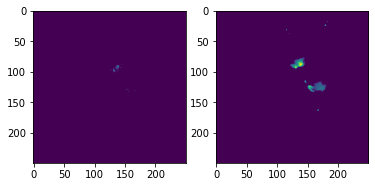

In [17]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(grid_ds.glm_freq[-1], vmin=0, vmax=5)
ax[1].imshow(ma.array(grid_ds.radar_ref[-1], mask=~grid_ds.radar_mask[-1]), vmin=0, vmax=40)

In [23]:
%%capture
fig, ax = plt.subplots(2,2,dpi=150, figsize=(7,6))

img_shape=grid_ds.glm_freq[0].shape
img00 = ax[0,0].imshow(np.zeros((*img_shape,3)))
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
img01 = ax[0,1].imshow(np.zeros(img_shape), vmin=180, vmax=320, cmap='inferno')
cbar01 = plt.colorbar(img01, ax=ax[0,1], label="Brightness temperature /K")
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
img10 = ax[1,0].imshow(np.zeros(img_shape), vmin=0, vmax=5)
cbar10 = plt.colorbar(img10, ax=ax[1,0], label="Flash frequency")
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
img11 = ax[1,1].imshow(np.zeros(img_shape), vmin=0, vmax=40)
cbar11 = plt.colorbar(img11, ax=ax[1,1], label="Radar reflectivity /dBz")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
t00 = ax[0,0].set_title('GOES-16 ABI RGB', loc='left', size=8)
t01 = ax[0,1].set_title('GOES-16 ABI C13', loc='left', size=8)
t10 = ax[1,0].set_title('GOES-16 GLM Flashes', loc='left', size=8)
t11 = ax[1,1].set_title('NEXRAD reflectivity', loc='left', size=8)

# init function: returns the plotting handles that will be modified
def init():
    img00.set_data(np.zeros((*img_shape,3)))
    img01.set_data(np.zeros(img_shape))
    img10.set_data(np.zeros(img_shape))
    img11.set_data(np.zeros(img_shape))
    return img00, img01, img10, img11

# animation function: modifies the data of the plot handles according to a frame index
def animate(i):
    rgbi = abi.get_abi_rgb(goes_ds.CMI_C01[i], goes_ds.CMI_C02[i], goes_ds.CMI_C03[i])
    img00.set_data(rgbi)
    img01.set_data(goes_ds.CMI_C13[i])
    img10.set_data(grid_ds.glm_freq[i])
    img11.set_data(ma.array(grid_ds.radar_ref[i], mask=~grid_ds.radar_mask[i]))
    return img00, img01, img10, img11

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=96, 
                               interval=100, repeat_delay=1000, blit=True)


In [24]:
# Embed using ipython
from IPython.display import HTML, Image, display
HTML(anim.to_html5_video())